Basic imports

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import random
import warnings
from glob import glob
from tqdm import tqdm
from PIL import Image
from io import BytesIO
import base64
warnings.filterwarnings("ignore")
%matplotlib inline

Read csv file and image paths

In [7]:
IMAGE_ROOT = "/content/drive/MyDrive/local_image_dataset/local_images"
CSV_PATH = "/content/drive/MyDrive/local_image_dataset/local_image_labels_fin_2_sorted_file.csv"

df = pd.read_csv(CSV_PATH)
image_paths = glob(IMAGE_ROOT + os.sep + "*.jpg")

In [8]:
files = os.listdir(IMAGE_ROOT)
num_files = len(files)
print("Number of files in the image folder:", num_files)

Number of files in the image folder: 4467


In [9]:
df

,Patient ID,IDH status,IDH-1P10Q Subtype,ATRX status,MGMT promoter status,TERT expression status,Cancer Type Detailed
0,0_0_TCGA-02-0006_BS1_001,0.0,0.0,1.0,0.0,0.0,G
1,0_0_TCGA-02-0007_BS1_001,0.0,0.0,1.0,0.0,0.0,G
2,0_0_TCGA-02-0010_BS1_001,1.0,0.0,1.0,0.0,0.0,G
3,0_0_TCGA-02-0016_BS1_001,0.0,0.0,1.0,1.0,0.0,G
4,0_0_TCGA-02-0026_BS1_001,1.0,0.0,1.0,1.0,0.0,G
...,...,...,...,...,...,...,...
4462,2_9_TCGA-HT-8011_BS1_001,0.0,0.0,0.0,0.0,1.0,A
4463,2_9_TCGA-HT-8015_TS1_001,0.0,0.0,0.0,0.0,0.0,A
4464,2_9_TCGA-S9-A6TS_TS1_001,1.0,0.0,1.0,1.0,0.0,A
4465,2_9_TCGA-WY-A858_TS1_001,1.0,0.0,1.0,1.0,0.0,A


## Deep Learning

### Dataset class creation

In [10]:
import torch
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

In [11]:
class ImageDataset(Dataset):
    def __init__(self, csv, train, test):
        self.csv = csv
        self.train = train
        self.test = test
        self.all_image_names = self.csv[:]['Patient ID']
        self.all_labels = np.array(self.csv.drop(['Patient ID','Cancer Type Detailed'], axis=1))
        self.train_ratio = int(0.85 * len(self.csv))
        self.valid_ratio = len(self.csv) - self.train_ratio
        # set the training data images and labels
        if self.train:
            print(f"Number of training images: {self.train_ratio}")
            self.image_names = list(self.all_image_names[:self.train_ratio])
            self.labels = list(self.all_labels[:self.train_ratio])
            # define the training transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomRotation(degrees=45),
                transforms.ToTensor(),
            ])
        # set the validation data images and labels
        elif self.train == False and self.test == False:
            print(f"Number of validation images: {self.valid_ratio}")
            self.image_names = list(self.all_image_names[-self.valid_ratio:-10])
            self.labels = list(self.all_labels[-self.valid_ratio:-10])
            # define the validation transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.Resize((400, 400)),
                transforms.ToTensor(),
            ])
        # set the test data images and labels, only last 10 images
        # this, we will use in a separate inference script
        elif self.test == True and self.train == False:
            self.image_names = list(self.all_image_names[-10:])
            self.labels = list(self.all_labels[-10:])
             # define the test transforms
            self.transform = transforms.Compose([
                transforms.ToPILImage(),
                transforms.ToTensor(),
            ])
    def __len__(self):
        return len(self.image_names)
    
    def __getitem__(self, index):
        image = cv2.imread(f"/content/drive/MyDrive/local_image_dataset/local_images/{self.image_names[index]}.jpg")
        # convert the image from BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # apply image transforms
        image = self.transform(image)
        targets = self.labels[index]
        
        return {
            'image': torch.tensor(image, dtype=torch.float32),
            'label': torch.tensor(targets, dtype=torch.float32)
        }

### Model creation
We use the EfficientNet-B0 model architecture

In [12]:
import torchvision.models as models
import torch.nn as nn

def build_model(pretrained=False, fine_tune=True, num_classes=5):
    if pretrained:
        print('[INFO]: Loading pre-trained weights')
    else:
        print('[INFO]: Not loading pre-trained weights')
    model = models.efficientnet_b0(pretrained=pretrained)
    if fine_tune:
        print('[INFO]: Fine-tuning all layers...')
        for params in model.parameters():
            params.requires_grad = True
    elif not fine_tune:
        print('[INFO]: Freezing hidden layers...')
        for params in model.parameters():
            params.requires_grad = False
    # Change the final classification head
    model.classifier[1] = nn.Linear(in_features=1280, out_features=num_classes)
    return model

### Custom Loss Function

In [13]:
# Finding number of positive and negative samples in each label 

N = len(df) 

labels = df.keys()[1:-1]

for k, label in enumerate(sorted(labels)):
    positives = sum(df[label] == 1)
    print(
      '{}:\tPositive Samples: {}\t\tNegative Samples: {}'
      .format(label, positives, N - positives)
    )

ATRX status:	Positive Samples: 2464		Negative Samples: 2003
IDH status:	Positive Samples: 2726		Negative Samples: 1741
IDH-1P10Q Subtype:	Positive Samples: 1339		Negative Samples: 3128
MGMT promoter status:	Positive Samples: 3614		Negative Samples: 853
TERT expression status:	Positive Samples: 1335		Negative Samples: 3132


In [14]:
# Calculating class weights for each label

class_weights = {}
positive_weights = {}
negative_weights = {}

for label in sorted(labels):
    positive_weights[label] = N /(2 * sum(df[label] == 1))
    negative_weights[label] = N /(2 * sum(df[label] == 0))
    
class_weights['positive_weights'] = positive_weights
class_weights['negative_weights'] = negative_weights

class_weights

{'positive_weights': {'ATRX status': 0.906452922077922,
  'IDH status': 0.8193323550990462,
  'IDH-1P10Q Subtype': 1.6680358476474981,
  'MGMT promoter status': 0.6180132816823465,
  'TERT expression status': 1.6730337078651685},
 'negative_weights': {'ATRX status': 1.115077383924114,
  'IDH status': 1.2828834003446294,
  'IDH-1P10Q Subtype': 0.71403452685422,
  'MGMT promoter status': 2.618405627198124,
  'TERT expression status': 0.7131226053639846}}

In [15]:
import torch
import torch.nn.functional as F

Wp = class_weights['positive_weights']
Wn = class_weights['negative_weights']

def custom_loss(y_true, y_pred):
    '''
    Multi-label cross-entropy
    * Required "Wp", "Wn" as positive & negative class-weights
    y_true: true value
    y_pred: predicted value
    '''
    loss = 0.0

    for i, key in enumerate(Wp.keys()):
        first_term = Wp[key] * y_true[:, i] * torch.log(y_pred[:, i] + 1e-7)
        second_term = Wn[key] * (1 - y_true[:, i]) * torch.log(1 - y_pred[:, i] + 1e-7)
        loss -= torch.sum(first_term + second_term)
    
    return loss

### Create train function

In [16]:
# training function
def train(model, dataloader, optimizer, criterion, train_data, device):
    print('Training')
    model.train()
    counter = 0
    train_running_loss = 0.0
    targets = []
    predictions = []
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data) / dataloader.batch_size)):
        counter += 1
        data, target = data['image'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        # apply sigmoid activation to get all the outputs between 0 and 1
        outputs = torch.sigmoid(outputs)
        binarized_outputs = torch.round(outputs)
        # binarized_outputs.requires_grad = True
        # binarized_outputs.retain_grad()
        # print("GT: ", target)
        # print("Prediction: ", binarized_outputs)
        # print(binarized_outputs.grad_fn)
        # print(binarized_outputs.requires_grad)
        loss = custom_loss(target, binarized_outputs)
        train_running_loss += loss.item()
        # backpropagation
        loss.backward()
        # update optimizer parameters
        optimizer.step()
        y_true = target.detach().cpu().numpy()
        y_pred = binarized_outputs.detach().cpu().numpy()
        # confustion_matrix = multilabel_confusion_matrix(y_true, y_pred)
        # print(confustion_matrix)
        # print(classification_report(y_true, y_pred))
        targets.append(y_true)
        predictions.append(y_pred)
    targets = np.concatenate(targets)
    predictions = np.concatenate(predictions)
    train_loss = train_running_loss / counter
    return train_loss, targets, predictions

### Create validation function

In [17]:
# validation function
def validate(model, dataloader, criterion, val_data, device):
    print('Validating')
    model.eval()
    counter = 0
    val_running_loss = 0.0
    targets = []
    predictions = []
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader), total=int(len(val_data)/dataloader.batch_size)):
            counter += 1
            data, target = data['image'].to(device), data['label'].to(device)
            outputs = model(data)
            # apply sigmoid activation to get all the outputs between 0 and 1
            outputs = torch.sigmoid(outputs)
            binarized_outputs = torch.round(outputs)
            loss = custom_loss(target, binarized_outputs)
            val_running_loss += loss.item()
            y_true = target.detach().cpu().numpy()
            y_pred = binarized_outputs.detach().cpu().numpy()
            targets.append(y_true)
            predictions.append(y_pred)
        val_loss = val_running_loss / counter
        targets = np.concatenate(targets)
        predictions = np.concatenate(predictions)
        return val_loss, targets, predictions

### Initiate model and start training

In [18]:
import torch.optim as optim
# initialize the computation device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [19]:
#intialize the model
model = build_model(pretrained=False, fine_tune=True, num_classes=5).to(device)
# learning parameters
lr = 1e-3
epochs = 30
batch_size = 32
optimizer = optim.Adam(model.parameters(), lr=lr)
# criterion = nn.BCELoss()

[INFO]: Not loading pre-trained weights
[INFO]: Fine-tuning all layers...


In [20]:
# train dataset
train_data = ImageDataset(df, train=True, test=False)
# validation dataset
valid_data = ImageDataset(df, train=False, test=False)
# train data loader
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
# validation data loader
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False)

Number of training images: 3796
Number of validation images: 671


### Defining Example Based metrics
Implementations are taken from [here](https://medium.datadriveninvestor.com/a-survey-of-evaluation-metrics-for-multilabel-classification-bb16e8cd41cd)
1.  Exact Match Ration (EMR)

In [21]:
def emr(y_true, y_pred):
    n = len(y_true)
    row_indicators = np.all(y_true == y_pred, axis = 1) # axis = 1 will check for equality along rows.
    exact_match_count = np.sum(row_indicators)
    return exact_match_count/n

# Example
gt = np.asarray([[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 1, 1], [0, 1, 0]])
pred = np.asarray([[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
print("EMR: ", emr(gt, pred))

EMR:  0.4


2. 1/0 Loss

In [22]:
def one_zero_loss(y_true, y_pred):
    n = len(y_true)
    row_indicators = np.logical_not(np.all(y_true == y_pred, axis = 1)) # axis = 1 will check for equality along rows.
    not_equal_count = np.sum(row_indicators)
    return not_equal_count/n

# Example
gt = np.asarray([[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 1, 1], [0, 1, 0]])
pred = np.asarray([[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
print("1/0 Loss: ", one_zero_loss(gt, pred))

1/0 Loss:  0.6


3. Hamming Loss

In [23]:
def hamming_loss(y_true, y_pred):
    """
	XOR TT for reference -

	A  B   Output

	0  0    0
	0  1    1
	1  0    1
	1  1    0
	"""
    hl_num = np.sum(np.logical_xor(y_true, y_pred))
    hl_den = np.prod(y_true.shape)

    return hl_num/hl_den

# Example
gt = np.asarray([[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 1, 1], [0, 1, 0]])
pred = np.asarray([[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
hl_value = hamming_loss(gt, pred)
print(f"Hamming Loss: {hl_value}")

Hamming Loss: 0.2


4. Example based accuracy

In [24]:
def example_based_accuracy(y_true, y_pred):

    # compute true positives using the logical AND operator
    numerator = np.sum(np.logical_and(y_true, y_pred), axis = 1)

    # compute true_positive + false negatives + false positive using the logical OR operator
    denominator = np.sum(np.logical_or(y_true, y_pred), axis = 1)
    instance_accuracy = numerator/denominator

    avg_accuracy = np.mean(instance_accuracy)
    return avg_accuracy

# Example
gt = np.asarray([[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 1, 1], [0, 1, 0]])
pred = np.asarray([[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
ex_based_accuracy = example_based_accuracy(gt, pred)
print(f"Example Based Accuracy: {ex_based_accuracy}")

Example Based Accuracy: 0.7


5. Example-Based Precision

In [25]:
def example_based_precision(y_true, y_pred):
    """
    precision = TP/ (TP + FP)
    """

    # Compute True Positive
    precision_num = np.sum(np.logical_and(y_true, y_pred), axis = 1)

    # Total number of pred true labels
    precision_den = np.sum(y_pred, axis = 1)

    # precision averaged over all training examples
    avg_precision = np.mean(precision_num/precision_den)

    return avg_precision

# Example
gt = np.asarray([[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 1, 1], [0, 1, 0]])
pred = np.asarray([[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
ex_based_precision = example_based_precision(gt, pred)
print(f"Example Based Precision: {ex_based_precision}")

Example Based Precision: 0.8


### Defining Label based metrics
1. Macro Averaged Accuracy

In [26]:
def label_based_macro_accuracy(y_true, y_pred):

    # axis = 0 computes true positives along columns i.e labels
    l_acc_num = np.sum(np.logical_and(y_true, y_pred), axis = 0)

    # axis = 0 computes true postive + false positive + false negatives along columns i.e labels
    l_acc_den = np.sum(np.logical_or(y_true, y_pred), axis = 0)

    # compute mean accuracy across labels.
    return np.mean(l_acc_num/l_acc_den)
# Example
gt = np.asarray([[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 1, 1], [0, 1, 0]])
pred = np.asarray([[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
lb_macro_acc_val = label_based_macro_accuracy(gt, pred)
print(f"Label Based Macro Accuracy: {lb_macro_acc_val}")

Label Based Macro Accuracy: 0.7222222222222222


2. Macro Averaged Precision

In [27]:
def label_based_macro_precision(y_true, y_pred):
 
    # axis = 0 computes true positive along columns i.e labels
    l_prec_num = np.sum(np.logical_and(y_true, y_pred), axis = 0)

    # axis = computes true_positive + false positive along columns i.e labels
    l_prec_den = np.sum(y_pred, axis = 0)

    # compute precision per class/label
    l_prec_per_class = l_prec_num/l_prec_den

    # macro precision = average of precsion across labels. 
    l_prec = np.mean(l_prec_per_class)
    return l_prec

# Example
gt = np.asarray([[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 1, 1], [0, 1, 0]])
pred = np.asarray([[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
lb_macro_precision_val = label_based_macro_precision(gt, pred)
print(f"Label Based Precision: {lb_macro_precision_val}")

Label Based Precision: 0.7777777777777777


3. Macro Averaged Recall

In [28]:
def label_based_macro_recall(y_true, y_pred):
    
    # compute true positive along axis = 0 i.e labels
    l_recall_num = np.sum(np.logical_and(y_true, y_pred), axis = 0)

    # compute true positive + false negatives along axis = 0 i.e columns
    l_recall_den = np.sum(y_true, axis = 0)

    # compute recall per class/label
    l_recall_per_class = l_recall_num/l_recall_den

    # compute macro averaged recall i.e recall averaged across labels. 
    l_recall = np.mean(l_recall_per_class)
    return l_recall

# Example
gt = np.asarray([[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 1, 1], [0, 1, 0]])
pred = np.asarray([[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
lb_macro_recall_val = label_based_macro_recall(gt, pred) 
print(f"Label Based Recall: {lb_macro_recall_val}")

Label Based Recall: 0.8888888888888888


4. Micro Averaged Accuracy

In [29]:
def label_based_micro_accuracy(y_true, y_pred):
    
    # sum of all true positives across all examples and labels 
    l_acc_num = np.sum(np.logical_and(y_true, y_pred))

    # sum of all tp+fp+fn across all examples and labels.
    l_acc_den = np.sum(np.logical_or(y_true, y_pred))

    # compute mirco averaged accuracy
    return l_acc_num/l_acc_den

# Example
gt = np.asarray([[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 1, 1], [0, 1, 0]])
pred = np.asarray([[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
lb_micro_acc_val = label_based_micro_accuracy(gt, pred)
print(f"Label Based Micro Accuracy: {lb_micro_acc_val}")

Label Based Micro Accuracy: 0.7272727272727273


5. Micro Averaged Precision

In [30]:
def label_based_micro_precision(y_true, y_pred):
    
    # compute sum of true positives (tp) across training examples
    # and labels. 
    l_prec_num = np.sum(np.logical_and(y_true, y_pred))

    # compute the sum of tp + fp across training examples and labels
    l_prec_den = np.sum(y_pred)

    # compute micro-averaged precision
    return l_prec_num/l_prec_den

# Example
gt = np.asarray([[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 1, 1], [0, 1, 0]])
pred = np.asarray([[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
lb_micro_prec_val = label_based_micro_precision(gt, pred)
print(f"Label Based Micro Precision: {lb_micro_prec_val}")

Label Based Micro Precision: 0.8


6. Micro Averaged Recall

In [31]:
def label_based_micro_recall(y_true, y_pred):
	
    # compute sum of true positives across training examples and labels.
    l_recall_num = np.sum(np.logical_and(y_true, y_pred))
    # compute sum of tp + fn across training examples and labels
    l_recall_den = np.sum(y_true)

    # compute mirco-average recall
    return l_recall_num/l_recall_den

# Example
gt = np.asarray([[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 1, 1], [0, 1, 0]])
pred = np.asarray([[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
lb_micro_recall_val = label_based_micro_recall(gt, pred)
print(f"Label Based Micro Recall: {lb_micro_recall_val}")

Label Based Micro Recall: 0.8888888888888888


### Defining F1 Score


In [32]:
import numpy as np

def f1_score(y_true, y_pred):
    '''
    Calculate F1 score
    y_true: true value
    y_pred: predicted value
    '''
    epsilon = 1e-7

    true_positives = np.sum(np.round(np.clip(y_true * y_pred, 0, 1)))
    possible_positives = np.sum(np.round(np.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + epsilon)
    predicted_positives = np.sum(np.round(np.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + epsilon)
    return (2 * precision * recall) / (precision + recall + epsilon)

# Example
gt = np.asarray([[1, 0, 1], [1, 1, 0], [1, 0, 0], [1, 1, 1], [0, 1, 0]])
pred = np.asarray([[1, 0, 1], [1, 0, 0], [1, 1, 0], [1, 1, 1], [0, 1, 1]])
f1_score = f1_score(gt, pred)
print(f"F1 Score: {f1_score}")

F1 Score: 0.8421052044321361


Starting training and validation

In [33]:
from sklearn.metrics import classification_report, multilabel_confusion_matrix
# start the training and validation
emr_list = []
one_zero_loss_list = []
hamming_loss_list = []
example_based_accuracy_list = []
example_based_precision_list = []
label_based_macro_accuracy_list = []
label_based_macro_precision_list = []
label_based_macro_recall_list = []
label_based_micro_accuracy_list = []
label_based_micro_precision_list = []
label_based_micro_recall_list = []
# f1_score_list= []

train_loss = []
valid_loss = []
for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    print("Training...")
    train_epoch_loss, targets, predictions = train(
        model, train_loader, optimizer, custom_loss, train_data, device
    )
    print("Classification Report")
    print(classification_report(targets, predictions))
    
    emr_score = emr(targets, predictions)
    one_zero_loss_score = one_zero_loss(targets, predictions)
    hamming_loss_score = hamming_loss(targets, predictions)
    example_based_accuracy_score = example_based_accuracy(targets, predictions)
    example_based_precision_score = example_based_precision(targets, predictions)
    label_based_macro_accuracy_score = label_based_macro_accuracy(targets, predictions)
    label_based_macro_precision_score = label_based_macro_precision(targets, predictions)
    label_based_macro_recall_score = label_based_macro_recall(targets, predictions)
    label_based_micro_accuracy_score = label_based_micro_accuracy(targets, predictions)
    label_based_micro_precision_score = label_based_micro_precision(targets, predictions)
    label_based_micro_recall_score = label_based_micro_recall(targets, predictions)
    # f1_score = f1_score(targets, predictions)

    emr_list.append(emr_score)
    one_zero_loss_list.append(one_zero_loss_score)
    hamming_loss_list.append(hamming_loss_score)
    example_based_accuracy_list.append(example_based_accuracy_score)
    example_based_precision_list.append(example_based_precision_score)
    label_based_macro_accuracy_list.append(label_based_macro_accuracy_score)
    label_based_macro_precision_list.append(label_based_macro_precision_score)
    label_based_macro_recall_list.append(label_based_macro_recall_score)
    label_based_micro_accuracy_list.append(label_based_micro_accuracy_score)
    label_based_micro_precision_list.append(label_based_micro_precision_score)
    label_based_micro_recall_list.append(label_based_micro_recall_score)
    # f1_score_list.append(f1_score)

    print("Exact match ratio: ", emr_score)
    print("1/0 Loss: ", one_zero_loss_score)
    print("Hamming Loss: ", hamming_loss_score)
    print("Example based Accuracy: ", example_based_accuracy_score)
    print("Example based precision: ", example_based_precision_score)
    print("Macro Averaged Accuracy: ", label_based_macro_accuracy_score)
    print("Macro Averaged Precision: ", label_based_macro_precision_score)
    print("Macro Averaged Recall: ", label_based_macro_recall_score)
    print("Micro Averaged Accuracy: ", label_based_micro_accuracy_score)
    print("Micro Averaged Precision: ", label_based_micro_precision_score)
    print("Micro Averaged Recall: ", label_based_micro_recall_score)
    # print("F1 Score:", f1_score)

    print("Validating...")
    valid_epoch_loss, val_targets, val_predictions = validate(
        model, valid_loader, custom_loss, valid_data, device
    )
    print("Classification Report")
    print(classification_report(val_targets, val_predictions))
    train_loss.append(train_epoch_loss)
    valid_loss.append(valid_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f'Val Loss: {valid_epoch_loss:.4f}')

Epoch 1 of 30
Training...
Training


119it [38:56, 19.63s/it]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.75      0.65      2157
           1       0.28      0.96      0.43      1046
           2       0.49      0.32      0.39      2185
           3       0.80      0.26      0.39      3036
           4       0.32      0.49      0.38      1059

   micro avg       0.44      0.49      0.46      9483
   macro avg       0.49      0.55      0.45      9483
weighted avg       0.57      0.49      0.45      9483
 samples avg       0.43      0.42      0.40      9483

Exact match ratio:  0.007112750263435195
1/0 Loss:  0.9928872497365648
Hamming Loss:  0.5630663856691254
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2956868877309638
Macro Averaged Precision:  0.49209772415393405
Macro Averaged Recall:  0.5548922205034865
Micro Averaged Accuracy:  0.30191390685217845
Micro Averaged Precision:  0.4423813169984686
Micro Averaged Recall:  0.4873985025835706
V

21it [06:34, 18.78s/it]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.97      0.58       275
           3       1.00      0.01      0.02       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.71      0.61      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.71      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1594.9259
Val Loss: 1150.9920
Epoch 2 of 30
Training...
Training


119it [01:27,  1.36it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.76      0.65      2157
           1       0.28      0.94      0.43      1046
           2       0.50      0.32      0.39      2185
           3       0.82      0.28      0.41      3036
           4       0.31      0.47      0.38      1059

   micro avg       0.45      0.49      0.47      9483
   macro avg       0.50      0.55      0.45      9483
weighted avg       0.57      0.49      0.46      9483
 samples avg       0.44      0.43      0.40      9483

Exact match ratio:  0.007903055848261328
1/0 Loss:  0.9920969441517387
Hamming Loss:  0.5596944151738672
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.298072161168968
Macro Averaged Precision:  0.4959247377548202
Macro Averaged Recall:  0.5541931760422035
Micro Averaged Accuracy:  0.30500490677134445
Micro Averaged Precision:  0.4455275229357798
Micro Averaged Recall:  0.4916165770325846
Val

21it [00:08,  2.57it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.98      0.58       275
           3       1.00      0.01      0.01       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1591.3699
Val Loss: 1151.6821
Epoch 3 of 30
Training...
Training


119it [01:28,  1.35it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.75      0.65      2157
           1       0.28      0.95      0.43      1046
           2       0.51      0.33      0.40      2185
           3       0.81      0.26      0.40      3036
           4       0.31      0.48      0.38      1059

   micro avg       0.44      0.49      0.46      9483
   macro avg       0.49      0.55      0.45      9483
weighted avg       0.57      0.49      0.45      9483
 samples avg       0.43      0.42      0.40      9483

Exact match ratio:  0.0050052687038988405
1/0 Loss:  0.9949947312961012
Hamming Loss:  0.5622760800842993
Example based Accuracy:  0.2900641025641026
Example based precision:  nan
Macro Averaged Accuracy:  0.2956760178533129
Macro Averaged Precision:  0.4946328369321071
Macro Averaged Recall:  0.5531948559504337
Micro Averaged Accuracy:  0.3023012552301255
Micro Averaged Precision:  0.4430391875059883
Micro Averaged Recall:  0.4876

21it [00:08,  2.58it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.97      0.58       275
           3       1.00      0.01      0.01       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1595.8829
Val Loss: 1154.2426
Epoch 4 of 30
Training...
Training


119it [01:29,  1.33it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.56      0.74      0.64      2157
           1       0.28      0.95      0.43      1046
           2       0.49      0.32      0.39      2185
           3       0.81      0.26      0.40      3036
           4       0.30      0.46      0.37      1059

   micro avg       0.44      0.48      0.46      9483
   macro avg       0.49      0.55      0.44      9483
weighted avg       0.57      0.48      0.45      9483
 samples avg       0.43      0.42      0.39      9483

Exact match ratio:  0.008166491043203371
1/0 Loss:  0.9918335089567967
Hamming Loss:  0.5679662802950474
Example based Accuracy:  0.28617843343870747
Example based precision:  nan
Macro Averaged Accuracy:  0.29113669390531066
Macro Averaged Precision:  0.48885638290799005
Macro Averaged Recall:  0.5478784945973372
Micro Averaged Accuracy:  0.2984511258622934
Micro Averaged Precision:  0.4380552106218359
Micro Averaged Recall:  0.48

21it [00:07,  2.68it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.98      0.58       275
           3       1.00      0.01      0.01       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.61      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1609.2852
Val Loss: 1150.6604
Epoch 5 of 30
Training...
Training


119it [01:29,  1.33it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.76      0.65      2157
           1       0.28      0.94      0.43      1046
           2       0.50      0.33      0.40      2185
           3       0.82      0.27      0.41      3036
           4       0.30      0.46      0.37      1059

   micro avg       0.44      0.49      0.47      9483
   macro avg       0.49      0.55      0.45      9483
weighted avg       0.57      0.49      0.46      9483
 samples avg       0.43      0.42      0.40      9483

Exact match ratio:  0.007639620653319284
1/0 Loss:  0.9923603793466808
Hamming Loss:  0.5631717597471022
Example based Accuracy:  0.29213645943098004
Example based precision:  nan
Macro Averaged Accuracy:  0.2961859545058226
Macro Averaged Precision:  0.4929833860099436
Macro Averaged Recall:  0.552910119123346
Micro Averaged Accuracy:  0.30342130987292276
Micro Averaged Precision:  0.44266970907016545
Micro Averaged Recall:  0.490

21it [00:08,  2.57it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.97      0.58       275
           3       1.00      0.01      0.01       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1597.7681
Val Loss: 1153.7683
Epoch 6 of 30
Training...
Training


119it [01:29,  1.33it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.75      0.65      2157
           1       0.27      0.94      0.42      1046
           2       0.52      0.35      0.42      2185
           3       0.80      0.25      0.39      3036
           4       0.31      0.48      0.38      1059

   micro avg       0.44      0.49      0.46      9483
   macro avg       0.49      0.55      0.45      9483
weighted avg       0.57      0.49      0.46      9483
 samples avg       0.43      0.43      0.40      9483

Exact match ratio:  0.01053740779768177
1/0 Loss:  0.9894625922023182
Hamming Loss:  0.5634351949420443
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.29657647385331354
Macro Averaged Precision:  0.4949602947313747
Macro Averaged Recall:  0.5542422367145192
Micro Averaged Accuracy:  0.3025955393243772
Micro Averaged Precision:  0.4422838623582118
Micro Averaged Recall:  0.4892966360856269
Val

21it [00:08,  2.56it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.97      0.58       275
           3       1.00      0.01      0.01       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1592.7757
Val Loss: 1153.2209
Epoch 7 of 30
Training...
Training


119it [01:29,  1.33it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.56      0.75      0.64      2157
           1       0.28      0.95      0.43      1046
           2       0.50      0.34      0.40      2185
           3       0.81      0.27      0.41      3036
           4       0.32      0.48      0.38      1059

   micro avg       0.44      0.49      0.47      9483
   macro avg       0.49      0.56      0.45      9483
weighted avg       0.57      0.49      0.46      9483
 samples avg       0.44      0.43      0.40      9483

Exact match ratio:  0.008166491043203371
1/0 Loss:  0.9918335089567967
Hamming Loss:  0.5609062170706006
Example based Accuracy:  0.29445468914647
Example based precision:  nan
Macro Averaged Accuracy:  0.2985660122173208
Macro Averaged Precision:  0.4945238573467762
Macro Averaged Recall:  0.5571040934548914
Micro Averaged Accuracy:  0.30509138381201045
Micro Averaged Precision:  0.4446770050423366
Micro Averaged Recall:  0.492881

21it [00:07,  2.68it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.97      0.58       275
           3       1.00      0.01      0.02       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1592.6187
Val Loss: 1152.7466
Epoch 8 of 30
Training...
Training


119it [01:29,  1.33it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.74      0.64      2157
           1       0.28      0.96      0.43      1046
           2       0.51      0.34      0.41      2185
           3       0.82      0.27      0.41      3036
           4       0.31      0.48      0.37      1059

   micro avg       0.44      0.49      0.47      9483
   macro avg       0.50      0.56      0.45      9483
weighted avg       0.57      0.49      0.46      9483
 samples avg       0.44      0.43      0.40      9483

Exact match ratio:  0.006059009483667018
1/0 Loss:  0.993940990516333
Hamming Loss:  0.5608535300316122
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2989796571780679
Macro Averaged Precision:  0.49708062236215805
Macro Averaged Recall:  0.5588704226374941
Micro Averaged Accuracy:  0.30570049569527785
Micro Averaged Precision:  0.4448557327258922
Micro Averaged Recall:  0.4942528735632184
Va

21it [00:07,  2.74it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.97      0.58       275
           3       1.00      0.01      0.02       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.61      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1587.0529
Val Loss: 1152.2722
Epoch 9 of 30
Training...
Training


119it [01:29,  1.33it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.75      0.65      2157
           1       0.28      0.95      0.43      1046
           2       0.50      0.33      0.40      2185
           3       0.81      0.27      0.40      3036
           4       0.31      0.47      0.38      1059

   micro avg       0.44      0.49      0.47      9483
   macro avg       0.49      0.55      0.45      9483
weighted avg       0.57      0.49      0.46      9483
 samples avg       0.43      0.42      0.40      9483

Exact match ratio:  0.005795574288724974
1/0 Loss:  0.994204425711275
Hamming Loss:  0.560958904109589
Example based Accuracy:  0.2910914998243766
Example based precision:  nan
Macro Averaged Accuracy:  0.2965517302368013
Macro Averaged Precision:  0.49413321181688313
Macro Averaged Recall:  0.5528552263782027
Micro Averaged Accuracy:  0.3032979976442874
Micro Averaged Precision:  0.44422081656124207
Micro Averaged Recall:  0.48876

21it [00:08,  2.54it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.97      0.58       275
           3       1.00      0.01      0.01       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.61      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1592.5819
Val Loss: 1151.7923
Epoch 10 of 30
Training...
Training


119it [01:29,  1.33it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.76      0.65      2157
           1       0.27      0.94      0.42      1046
           2       0.50      0.32      0.39      2185
           3       0.80      0.25      0.38      3036
           4       0.31      0.46      0.37      1059

   micro avg       0.44      0.48      0.46      9483
   macro avg       0.49      0.55      0.44      9483
weighted avg       0.57      0.48      0.45      9483
 samples avg       0.43      0.42      0.39      9483

Exact match ratio:  0.00684931506849315
1/0 Loss:  0.9931506849315068
Hamming Loss:  0.5642255005268704
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2926884681205979
Macro Averaged Precision:  0.49129591736426564
Macro Averaged Recall:  0.5473202718195388
Micro Averaged Accuracy:  0.29965339088352627
Micro Averaged Precision:  0.44100096246390763
Micro Averaged Recall:  0.4831804281345566
V

21it [00:08,  2.57it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.97      0.57       275
           3       1.00      0.01      0.02       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1602.0120
Val Loss: 1154.0268
Epoch 11 of 30
Training...
Training


119it [01:29,  1.33it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.75      0.65      2157
           1       0.27      0.93      0.42      1046
           2       0.51      0.33      0.40      2185
           3       0.82      0.27      0.41      3036
           4       0.31      0.46      0.37      1059

   micro avg       0.44      0.49      0.46      9483
   macro avg       0.49      0.55      0.45      9483
weighted avg       0.57      0.49      0.46      9483
 samples avg       0.44      0.43      0.40      9483

Exact match ratio:  0.008429926238145416
1/0 Loss:  0.9915700737618546
Hamming Loss:  0.5624341412012644
Example based Accuracy:  0.2917939936775553
Example based precision:  nan
Macro Averaged Accuracy:  0.29545954771285177
Macro Averaged Precision:  0.49434427753252164
Macro Averaged Recall:  0.5490009543740857
Micro Averaged Accuracy:  0.3021963655379788
Micro Averaged Precision:  0.4429009388771795
Micro Averaged Recall:  0.487

21it [00:07,  2.70it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.97      0.58       275
           3       1.00      0.01      0.01       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1596.4736
Val Loss: 1152.4880
Epoch 12 of 30
Training...
Training


119it [01:29,  1.33it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.76      0.65      2157
           1       0.28      0.95      0.43      1046
           2       0.50      0.32      0.39      2185
           3       0.80      0.26      0.40      3036
           4       0.33      0.49      0.39      1059

   micro avg       0.45      0.49      0.47      9483
   macro avg       0.50      0.56      0.45      9483
weighted avg       0.57      0.49      0.46      9483
 samples avg       0.43      0.42      0.40      9483

Exact match ratio:  0.006322444678609062
1/0 Loss:  0.9936775553213909
Hamming Loss:  0.5590094836670179
Example based Accuracy:  0.29220670881629784
Example based precision:  nan
Macro Averaged Accuracy:  0.29866875790302244
Macro Averaged Precision:  0.4952372905463577
Macro Averaged Recall:  0.5571749417993983
Micro Averaged Accuracy:  0.3049914843442945
Micro Averaged Precision:  0.4460197336909666
Micro Averaged Recall:  0.490

21it [00:07,  2.76it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.97      0.58       275
           3       1.00      0.01      0.01       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1591.4136
Val Loss: 1152.2666
Epoch 13 of 30
Training...
Training


119it [01:29,  1.33it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.75      0.65      2157
           1       0.27      0.94      0.42      1046
           2       0.49      0.32      0.39      2185
           3       0.80      0.26      0.39      3036
           4       0.31      0.48      0.38      1059

   micro avg       0.44      0.49      0.46      9483
   macro avg       0.49      0.55      0.45      9483
weighted avg       0.56      0.49      0.45      9483
 samples avg       0.43      0.42      0.39      9483

Exact match ratio:  0.007376185458377239
1/0 Loss:  0.9926238145416227
Hamming Loss:  0.5663329820864067
Example based Accuracy:  0.28751756234632947
Example based precision:  nan
Macro Averaged Accuracy:  0.29307060371089816
Macro Averaged Precision:  0.489545847436196
Macro Averaged Recall:  0.5498020611276555
Micro Averaged Accuracy:  0.2996937911264578
Micro Averaged Precision:  0.4395184406650105
Micro Averaged Recall:  0.4850

21it [00:08,  2.58it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.97      0.58       275
           3       1.00      0.01      0.01       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1608.3252
Val Loss: 1153.2209
Epoch 14 of 30
Training...
Training


119it [01:29,  1.33it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.75      0.65      2157
           1       0.28      0.94      0.43      1046
           2       0.51      0.34      0.41      2185
           3       0.80      0.25      0.39      3036
           4       0.31      0.48      0.38      1059

   micro avg       0.44      0.49      0.46      9483
   macro avg       0.49      0.55      0.45      9483
weighted avg       0.57      0.49      0.46      9483
 samples avg       0.43      0.43      0.40      9483

Exact match ratio:  0.007376185458377239
1/0 Loss:  0.9926238145416227
Hamming Loss:  0.5623287671232877
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2968628833771622
Macro Averaged Precision:  0.49406787271627917
Macro Averaged Recall:  0.5549292763137942
Micro Averaged Accuracy:  0.3028739386022208
Micro Averaged Precision:  0.44313837920489296
Micro Averaged Recall:  0.48898028050195086


21it [00:08,  2.56it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.97      0.58       275
           3       1.00      0.01      0.01       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1590.5888
Val Loss: 1154.2426
Epoch 15 of 30
Training...
Training


119it [01:29,  1.33it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.76      0.65      2157
           1       0.27      0.94      0.42      1046
           2       0.50      0.33      0.40      2185
           3       0.81      0.26      0.39      3036
           4       0.33      0.51      0.40      1059

   micro avg       0.44      0.49      0.47      9483
   macro avg       0.50      0.56      0.45      9483
weighted avg       0.57      0.49      0.46      9483
 samples avg       0.43      0.43      0.40      9483

Exact match ratio:  0.007639620653319284
1/0 Loss:  0.9923603793466808
Hamming Loss:  0.562118018967334
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.29868915021849823
Macro Averaged Precision:  0.49569129694476005
Macro Averaged Recall:  0.5591217735424369
Micro Averaged Accuracy:  0.30431664058424623
Micro Averaged Precision:  0.44363117870722435
Micro Averaged Recall:  0.4921438363387114


21it [00:07,  2.69it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.97      0.58       275
           3       1.00      0.01      0.01       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1590.4033
Val Loss: 1153.7683
Epoch 16 of 30
Training...
Training


119it [01:29,  1.33it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.74      0.64      2157
           1       0.28      0.95      0.43      1046
           2       0.50      0.33      0.40      2185
           3       0.82      0.27      0.40      3036
           4       0.31      0.46      0.37      1059

   micro avg       0.44      0.49      0.46      9483
   macro avg       0.50      0.55      0.45      9483
weighted avg       0.57      0.49      0.46      9483
 samples avg       0.43      0.42      0.40      9483

Exact match ratio:  0.007903055848261328
1/0 Loss:  0.9920969441517387
Hamming Loss:  0.5622760800842993
Example based Accuracy:  0.2912407797681771
Example based precision:  nan
Macro Averaged Accuracy:  0.2953699503402015
Macro Averaged Precision:  0.4955530261081932
Macro Averaged Recall:  0.550600088841377
Micro Averaged Accuracy:  0.3023012552301255
Micro Averaged Precision:  0.4430391875059883
Micro Averaged Recall:  0.487609

21it [00:07,  2.76it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.97      0.58       275
           3       1.00      0.01      0.01       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1591.3103
Val Loss: 1153.7683
Epoch 17 of 30
Training...
Training


119it [01:29,  1.33it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.56      0.75      0.64      2157
           1       0.28      0.94      0.43      1046
           2       0.50      0.32      0.39      2185
           3       0.80      0.26      0.39      3036
           4       0.32      0.49      0.39      1059

   micro avg       0.44      0.48      0.46      9483
   macro avg       0.49      0.55      0.45      9483
weighted avg       0.56      0.48      0.45      9483
 samples avg       0.43      0.42      0.39      9483

Exact match ratio:  0.006059009483667018
1/0 Loss:  0.993940990516333
Hamming Loss:  0.5667017913593256
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2930861261337159
Macro Averaged Precision:  0.4903920263662598
Macro Averaged Recall:  0.5513002465453495
Micro Averaged Accuracy:  0.29937467430953624
Micro Averaged Precision:  0.43917821309125654
Micro Averaged Recall:  0.4846567541917115
Va

21it [00:08,  2.57it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.97      0.58       275
           3       1.00      0.01      0.01       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1606.1910
Val Loss: 1153.7683
Epoch 18 of 30
Training...
Training


119it [01:29,  1.34it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.76      0.65      2157
           1       0.27      0.93      0.42      1046
           2       0.49      0.33      0.39      2185
           3       0.82      0.26      0.40      3036
           4       0.31      0.47      0.37      1059

   micro avg       0.44      0.49      0.46      9483
   macro avg       0.49      0.55      0.45      9483
weighted avg       0.57      0.49      0.45      9483
 samples avg       0.43      0.42      0.40      9483

Exact match ratio:  0.007112750263435195
1/0 Loss:  0.9928872497365648
Hamming Loss:  0.5651738672286617
Example based Accuracy:  0.2885230066736916
Example based precision:  nan
Macro Averaged Accuracy:  0.2941231653454268
Macro Averaged Precision:  0.4915059177758717
Macro Averaged Recall:  0.5493634335039266
Micro Averaged Accuracy:  0.3007626621471873
Micro Averaged Precision:  0.4406035141329259
Micro Averaged Recall:  0.48655

21it [00:08,  2.55it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.98      0.58       275
           3       1.00      0.01      0.01       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1599.5041
Val Loss: 1152.7768
Epoch 19 of 30
Training...
Training


119it [01:29,  1.33it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.75      0.65      2157
           1       0.27      0.94      0.43      1046
           2       0.51      0.33      0.40      2185
           3       0.82      0.27      0.41      3036
           4       0.30      0.45      0.36      1059

   micro avg       0.45      0.49      0.47      9483
   macro avg       0.50      0.55      0.45      9483
weighted avg       0.58      0.49      0.46      9483
 samples avg       0.44      0.42      0.40      9483

Exact match ratio:  0.008429926238145416
1/0 Loss:  0.9915700737618546
Hamming Loss:  0.5596417281348788
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2966946614727329
Macro Averaged Precision:  0.49646688844156506
Macro Averaged Recall:  0.5495825029193879
Micro Averaged Accuracy:  0.3038862310767416
Micro Averaged Precision:  0.4453087486795352
Micro Averaged Recall:  0.48898028050195086
V

21it [00:07,  2.68it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.98      0.58       275
           3       1.00      0.01      0.01       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1589.9406
Val Loss: 1152.2294
Epoch 20 of 30
Training...
Training


119it [01:29,  1.33it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.56      0.74      0.64      2157
           1       0.28      0.95      0.43      1046
           2       0.50      0.34      0.40      2185
           3       0.80      0.26      0.39      3036
           4       0.31      0.46      0.37      1059

   micro avg       0.44      0.49      0.46      9483
   macro avg       0.49      0.55      0.45      9483
weighted avg       0.56      0.49      0.45      9483
 samples avg       0.43      0.42      0.40      9483

Exact match ratio:  0.0050052687038988405
1/0 Loss:  0.9949947312961012
Hamming Loss:  0.5660168598524763
Example based Accuracy:  0.28799174569722513
Example based precision:  nan
Macro Averaged Accuracy:  0.29307042202186123
Macro Averaged Precision:  0.4897360672257041
Macro Averaged Recall:  0.5498173083127956
Micro Averaged Accuracy:  0.3000390930414386
Micro Averaged Precision:  0.43982808022922637
Micro Averaged Recall:  0.4

21it [00:07,  2.64it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.98      0.58       275
           3       1.00      0.01      0.01       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1604.6707
Val Loss: 1151.4965
Epoch 21 of 30
Training...
Training


119it [01:30,  1.31it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.58      0.76      0.66      2157
           1       0.28      0.96      0.43      1046
           2       0.51      0.33      0.40      2185
           3       0.80      0.25      0.38      3036
           4       0.32      0.49      0.39      1059

   micro avg       0.44      0.49      0.47      9483
   macro avg       0.49      0.56      0.45      9483
weighted avg       0.57      0.49      0.45      9483
 samples avg       0.43      0.42      0.40      9483

Exact match ratio:  0.008429926238145416
1/0 Loss:  0.9915700737618546
Hamming Loss:  0.5611696522655427
Example based Accuracy:  0.29201352300667366
Example based precision:  nan
Macro Averaged Accuracy:  0.2979394104135531
Macro Averaged Precision:  0.4947813425420463
Macro Averaged Recall:  0.5587970330211924
Micro Averaged Accuracy:  0.3041290996994643
Micro Averaged Precision:  0.4442641725520137
Micro Averaged Recall:  0.4908

21it [00:08,  2.50it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.97      0.58       275
           3       1.00      0.01      0.01       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1590.2481
Val Loss: 1154.2426
Epoch 22 of 30
Training...
Training


119it [01:30,  1.31it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.58      0.75      0.65      2157
           1       0.27      0.94      0.42      1046
           2       0.50      0.33      0.40      2185
           3       0.80      0.26      0.39      3036
           4       0.32      0.48      0.38      1059

   micro avg       0.44      0.49      0.46      9483
   macro avg       0.49      0.55      0.45      9483
weighted avg       0.57      0.49      0.45      9483
 samples avg       0.43      0.42      0.40      9483

Exact match ratio:  0.010273972602739725
1/0 Loss:  0.9897260273972602
Hamming Loss:  0.5620126448893572
Example based Accuracy:  0.2897787144362487
Example based precision:  nan
Macro Averaged Accuracy:  0.2955533098044124
Macro Averaged Precision:  0.49371949004581384
Macro Averaged Recall:  0.5508401051322755
Micro Averaged Accuracy:  0.3017608169143156
Micro Averaged Precision:  0.4430988081507113
Micro Averaged Recall:  0.4861

21it [00:08,  2.54it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.97      0.58       275
           3       1.00      0.01      0.01       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1595.3133
Val Loss: 1153.7683
Epoch 23 of 30
Training...
Training


119it [01:30,  1.32it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.75      0.64      2157
           1       0.27      0.94      0.42      1046
           2       0.52      0.34      0.41      2185
           3       0.81      0.27      0.41      3036
           4       0.30      0.46      0.36      1059

   micro avg       0.44      0.49      0.47      9483
   macro avg       0.49      0.55      0.45      9483
weighted avg       0.57      0.49      0.46      9483
 samples avg       0.44      0.43      0.40      9483

Exact match ratio:  0.007112750263435195
1/0 Loss:  0.9928872497365648
Hamming Loss:  0.5624868282402529
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.29644359250316443
Macro Averaged Precision:  0.49441351748356965
Macro Averaged Recall:  0.5519688219566425
Micro Averaged Accuracy:  0.3034059767714994
Micro Averaged Precision:  0.44315257790908225
Micro Averaged Recall:  0.49035115469788043

21it [00:07,  2.68it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.97      0.58       275
           3       1.00      0.01      0.02       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1596.6273
Val Loss: 1152.7466
Epoch 24 of 30
Training...
Training


119it [01:29,  1.32it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.74      0.64      2157
           1       0.28      0.95      0.43      1046
           2       0.50      0.33      0.39      2185
           3       0.82      0.27      0.40      3036
           4       0.32      0.49      0.39      1059

   micro avg       0.44      0.49      0.46      9483
   macro avg       0.50      0.55      0.45      9483
weighted avg       0.57      0.49      0.46      9483
 samples avg       0.43      0.43      0.40      9483

Exact match ratio:  0.008429926238145416
1/0 Loss:  0.9915700737618546
Hamming Loss:  0.5614857744994731
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2971680265107207
Macro Averaged Precision:  0.4973821115162326
Macro Averaged Recall:  0.554850419407261
Micro Averaged Accuracy:  0.30287172107019034
Micro Averaged Precision:  0.4437416139543799
Micro Averaged Recall:  0.4882421174733734
Val

21it [00:08,  2.54it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.97      0.58       275
           3       1.00      0.01      0.01       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1589.3139
Val Loss: 1153.7683
Epoch 25 of 30
Training...
Training


119it [01:29,  1.33it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.75      0.65      2157
           1       0.27      0.94      0.42      1046
           2       0.49      0.32      0.39      2185
           3       0.82      0.27      0.40      3036
           4       0.31      0.47      0.37      1059

   micro avg       0.44      0.49      0.46      9483
   macro avg       0.49      0.55      0.45      9483
weighted avg       0.57      0.49      0.45      9483
 samples avg       0.43      0.43      0.40      9483

Exact match ratio:  0.008956796628029505
1/0 Loss:  0.9910432033719705
Hamming Loss:  0.5648577449947313
Example based Accuracy:  0.29043730242360377
Example based precision:  nan
Macro Averaged Accuracy:  0.29461676728522396
Macro Averaged Precision:  0.4929462927319733
Macro Averaged Recall:  0.5514831239592812
Micro Averaged Accuracy:  0.30147250456085484
Micro Averaged Precision:  0.44100266869996185
Micro Averaged Recall:  0.4

21it [00:08,  2.53it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.98      0.58       275
           3       1.00      0.01      0.01       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1599.2649
Val Loss: 1152.0810
Epoch 26 of 30
Training...
Training


119it [01:29,  1.32it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.75      0.65      2157
           1       0.28      0.94      0.43      1046
           2       0.51      0.34      0.41      2185
           3       0.82      0.27      0.40      3036
           4       0.29      0.46      0.36      1059

   micro avg       0.44      0.49      0.46      9483
   macro avg       0.49      0.55      0.45      9483
weighted avg       0.57      0.49      0.46      9483
 samples avg       0.43      0.42      0.40      9483

Exact match ratio:  0.008956796628029505
1/0 Loss:  0.9910432033719705
Hamming Loss:  0.56390937829294
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.29536853891885934
Macro Averaged Precision:  0.4935200956885268
Macro Averaged Recall:  0.5505040718965032
Micro Averaged Accuracy:  0.302418040800365
Micro Averaged Precision:  0.4419047619047619
Micro Averaged Recall:  0.4892966360856269
Valid

21it [00:07,  2.70it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.97      0.57       275
           3       1.00      0.01      0.02       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1594.6152
Val Loss: 1153.5525
Epoch 27 of 30
Training...
Training


119it [01:29,  1.32it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.75      0.65      2157
           1       0.28      0.95      0.43      1046
           2       0.50      0.33      0.40      2185
           3       0.81      0.26      0.40      3036
           4       0.31      0.47      0.37      1059

   micro avg       0.44      0.49      0.46      9483
   macro avg       0.49      0.55      0.45      9483
weighted avg       0.57      0.49      0.45      9483
 samples avg       0.43      0.42      0.40      9483

Exact match ratio:  0.007639620653319284
1/0 Loss:  0.9923603793466808
Hamming Loss:  0.5641201264488935
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.2949052433992378
Macro Averaged Precision:  0.4927982983018393
Macro Averaged Recall:  0.5522369184600326
Micro Averaged Accuracy:  0.3013832702596894
Micro Averaged Precision:  0.4415025807684955
Micro Averaged Recall:  0.48708214699989455
Va

21it [00:07,  2.66it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.98      0.58       275
           3       1.00      0.01      0.01       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1599.3148
Val Loss: 1151.6821
Epoch 28 of 30
Training...
Training


119it [01:29,  1.33it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.75      0.65      2157
           1       0.27      0.94      0.42      1046
           2       0.49      0.32      0.39      2185
           3       0.81      0.27      0.40      3036
           4       0.31      0.48      0.38      1059

   micro avg       0.44      0.49      0.46      9483
   macro avg       0.49      0.55      0.45      9483
weighted avg       0.57      0.49      0.45      9483
 samples avg       0.43      0.42      0.40      9483

Exact match ratio:  0.007639620653319284
1/0 Loss:  0.9923603793466808
Hamming Loss:  0.5654899894625922
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.29477028236494823
Macro Averaged Precision:  0.49076405690330216
Macro Averaged Recall:  0.5525456437754709
Micro Averaged Accuracy:  0.3013279520895717
Micro Averaged Precision:  0.44052150742291585
Micro Averaged Recall:  0.4881366656121481


21it [00:08,  2.46it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.97      0.58       275
           3       1.00      0.01      0.01       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1604.1165
Val Loss: 1153.7683
Epoch 29 of 30
Training...
Training


119it [01:29,  1.32it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.76      0.65      2157
           1       0.28      0.95      0.43      1046
           2       0.49      0.32      0.39      2185
           3       0.82      0.27      0.41      3036
           4       0.31      0.48      0.38      1059

   micro avg       0.44      0.49      0.47      9483
   macro avg       0.49      0.55      0.45      9483
weighted avg       0.57      0.49      0.46      9483
 samples avg       0.43      0.43      0.40      9483

Exact match ratio:  0.007112750263435195
1/0 Loss:  0.9928872497365648
Hamming Loss:  0.5643308746048472
Example based Accuracy:  0.29170179135932567
Example based precision:  nan
Macro Averaged Accuracy:  0.2960414472711966
Macro Averaged Precision:  0.49162140691559697
Macro Averaged Recall:  0.554909294909714
Micro Averaged Accuracy:  0.30294155928673694
Micro Averaged Precision:  0.44173467451129245
Micro Averaged Recall:  0.49

21it [00:08,  2.60it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.85      0.99      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.97      0.58       275
           3       1.00      0.01      0.01       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1599.0021
Val Loss: 1153.0725
Epoch 30 of 30
Training...
Training


119it [01:29,  1.32it/s]


Classification Report
              precision    recall  f1-score   support

           0       0.57      0.75      0.65      2157
           1       0.27      0.94      0.42      1046
           2       0.49      0.31      0.38      2185
           3       0.82      0.28      0.41      3036
           4       0.32      0.48      0.38      1059

   micro avg       0.44      0.49      0.46      9483
   macro avg       0.49      0.55      0.45      9483
weighted avg       0.57      0.49      0.46      9483
 samples avg       0.43      0.42      0.40      9483

Exact match ratio:  0.00869336143308746
1/0 Loss:  0.9913066385669126
Hamming Loss:  0.5622233930453109
Example based Accuracy:  nan
Example based precision:  nan
Macro Averaged Accuracy:  0.29563323286237975
Macro Averaged Precision:  0.493931890225806
Macro Averaged Recall:  0.5509628044695744
Micro Averaged Accuracy:  0.30209287115761935
Micro Averaged Precision:  0.44302704776520235
Micro Averaged Recall:  0.48708214699989455
V

21it [00:07,  2.74it/s]

Classification Report
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       563
           1       0.44      1.00      0.61       292
           2       0.41      0.98      0.58       275
           3       1.00      0.01      0.01       572
           4       0.42      1.00      0.59       274

   micro avg       0.53      0.70      0.60      1976
   macro avg       0.62      0.79      0.54      1976
weighted avg       0.71      0.70      0.52      1976
 samples avg       0.53      0.65      0.57      1976

Train Loss: 1598.2049
Val Loss: 1152.2294


In [34]:
# Saving the trained model to disk
torch.save({
            'epoch': epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': custom_loss,
            }, '/content/drive/MyDrive/outputs/efficientnetb0_braintumor_local.pth')


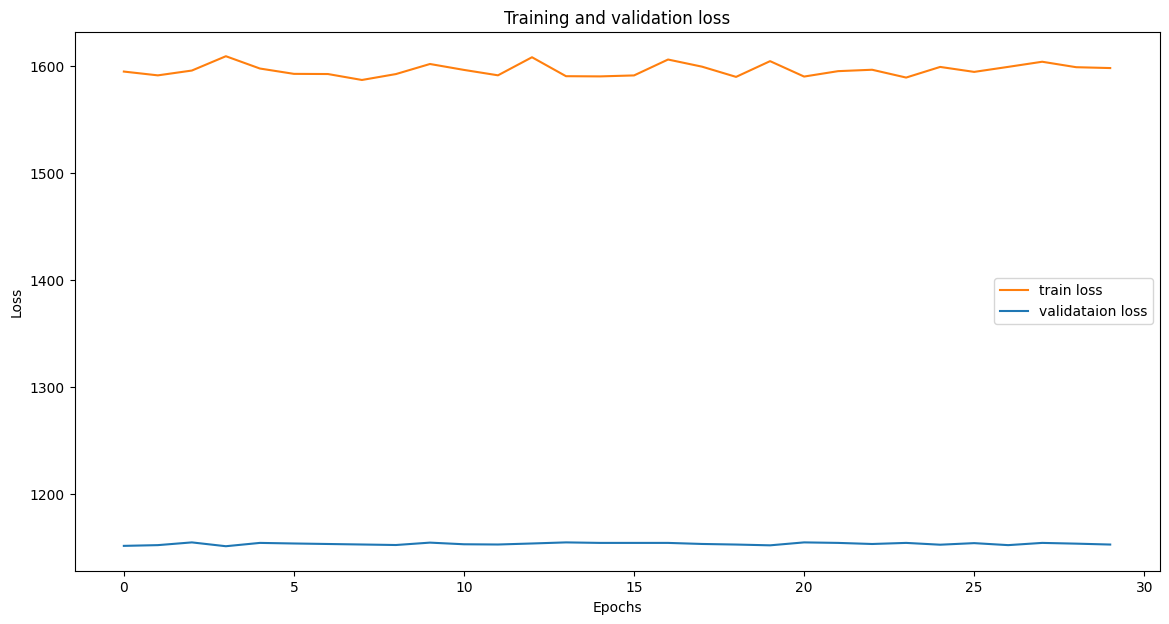

In [35]:
# Plotting the train and validation loss graphs

fig_1 = plt.figure(figsize=(14, 7))
plt.plot(train_loss, 'tab:orange', label='train loss')
plt.plot(valid_loss, 'tab:blue', label='validataion loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc ='best')
plt.show()

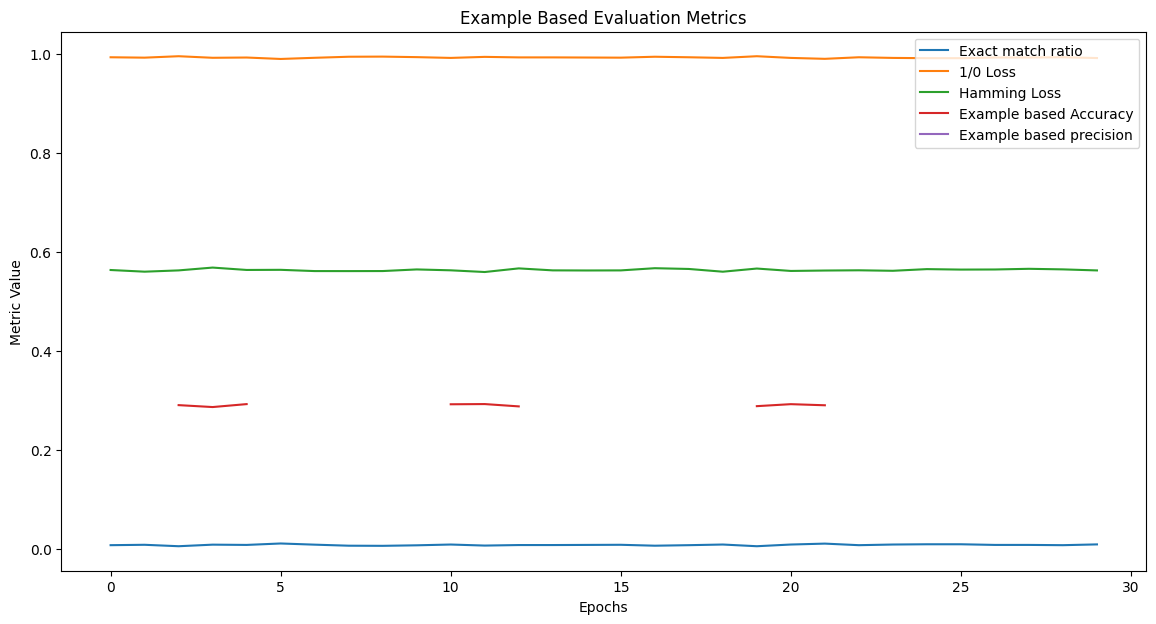

In [36]:
fig_2 = plt.figure(figsize = (14, 7))
plt.plot(emr_list, 'tab:blue', label='Exact match ratio')
plt.plot(one_zero_loss_list, 'tab:orange', label='1/0 Loss')
plt.plot(hamming_loss_list, 'tab:green', label='Hamming Loss')
plt.plot(example_based_accuracy_list, 'tab:red', label='Example based Accuracy')
plt.plot(example_based_precision_list, 'tab:purple', label='Example based precision')
plt.title('Example Based Evaluation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.legend(loc ='best')
plt.show()

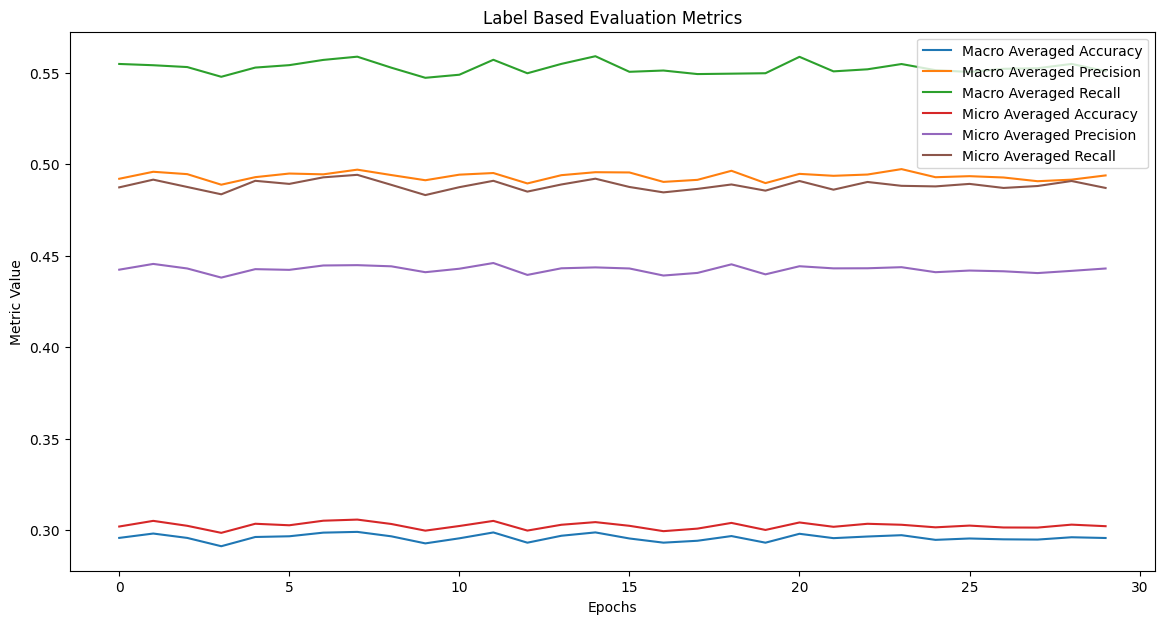

In [37]:
fig_3 = plt.figure(figsize = (14, 7))
plt.plot(label_based_macro_accuracy_list, 'tab:blue', label='Macro Averaged Accuracy')
plt.plot(label_based_macro_precision_list, 'tab:orange', label='Macro Averaged Precision')
plt.plot(label_based_macro_recall_list, 'tab:green', label='Macro Averaged Recall')
plt.plot(label_based_micro_accuracy_list, 'tab:red', label='Micro Averaged Accuracy')
plt.plot(label_based_micro_precision_list, 'tab:purple', label='Micro Averaged Precision')
plt.plot(label_based_micro_recall_list, 'tab:brown', label='Micro Averaged Recall')
# plt.plot(f1_score_list, 'tab:gray', label='F1 Score')
plt.title('Label Based Evaluation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metric Value')
plt.legend(loc ='best')
plt.show()